In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## Data cleaning

First we clean the data and see conflicting or damaged files in the dataset.

In [2]:
# Define the path to the GTZAN dataset
dataset_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'

We can get a list with all the genres considered in the dataset and how many songs are related to each genre. What we found is that there are 10 genres and 100 songs per genre.

In [3]:
import os

genres = os.listdir(dataset_path)
print("Genres:", genres)

for genre in genres:
    files = os.listdir(os.path.join(dataset_path, genre))
    print(f"{genre} has {len(files)} files.")


Genres: ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']
disco has 100 files.
metal has 100 files.
reggae has 100 files.
blues has 100 files.
rock has 100 files.
classical has 100 files.
jazz has 100 files.
hiphop has 100 files.
country has 100 files.
pop has 100 files.


We load a sample from the dataset. We can see that the length is 661504 as a result of the extend of the audio in seconds multiplied by the sample rate, which is 22050 in this case.

In [4]:
import librosa
import numpy as np

# Example of loading an audio file
file_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00001.wav'
audio, sr = librosa.load(file_path, sr=22050)  # Load with 22,050 Hz sampling rate

print("Audio Shape:", audio.shape)
print("Sampling Rate:", sr)


Audio Shape: (661504,)
Sampling Rate: 22050


We can reproduce the sample to find out if the sample rate is according to the songs in the dataset.

In [5]:
from IPython.display import Audio
Audio(data=audio, rate=sr)

One way to visualize the audio data is with plots of the wave frequencies through the duration time of the song.

We can see that every genre can be differentiated in some way and that there are not similar plots.

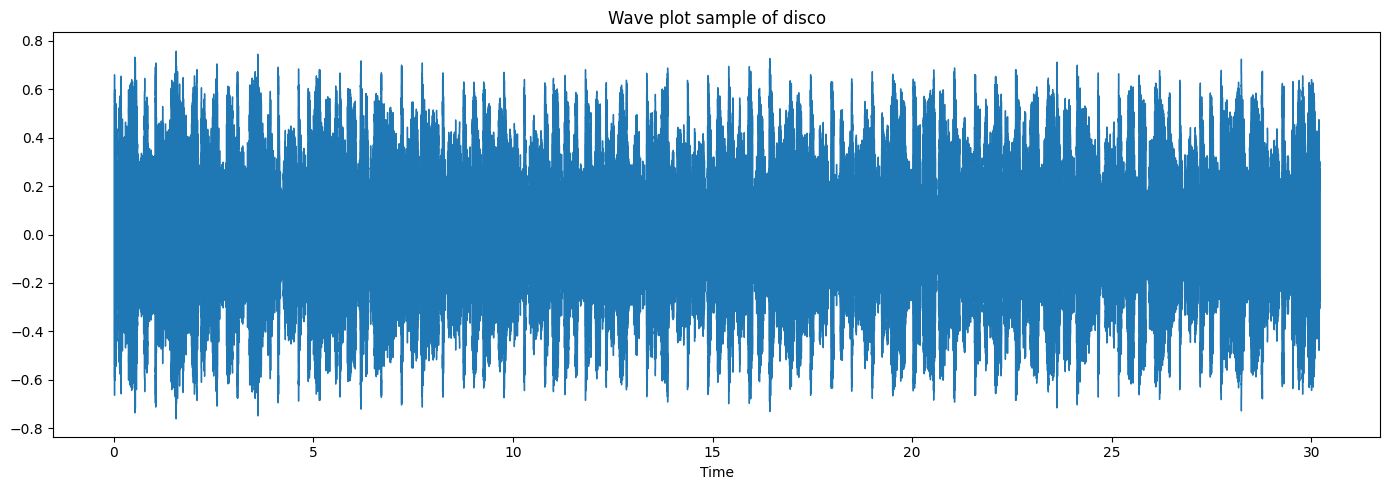

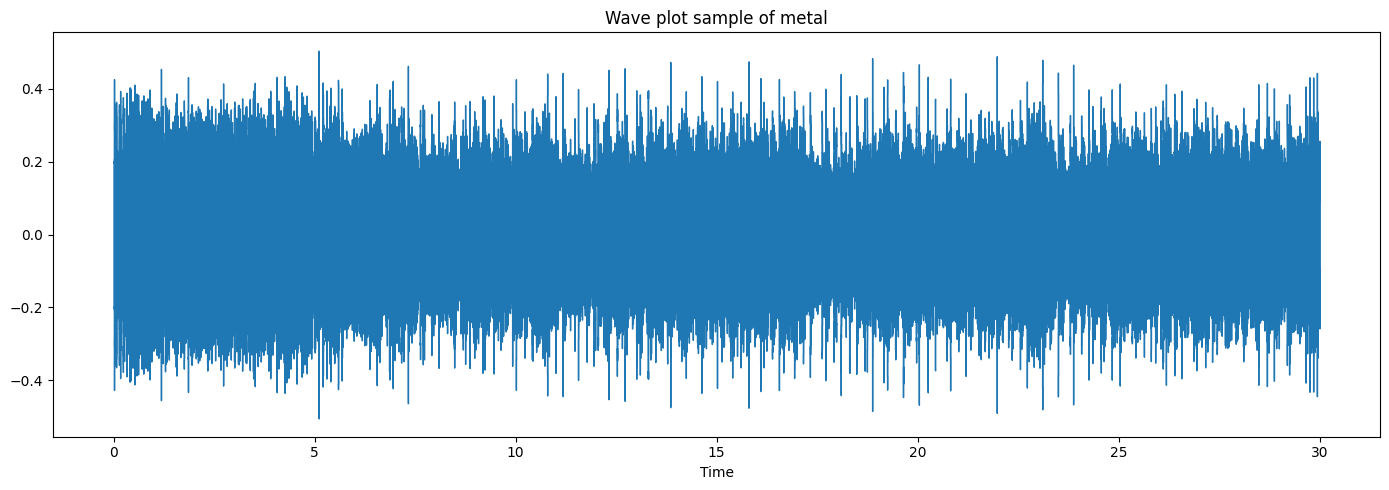

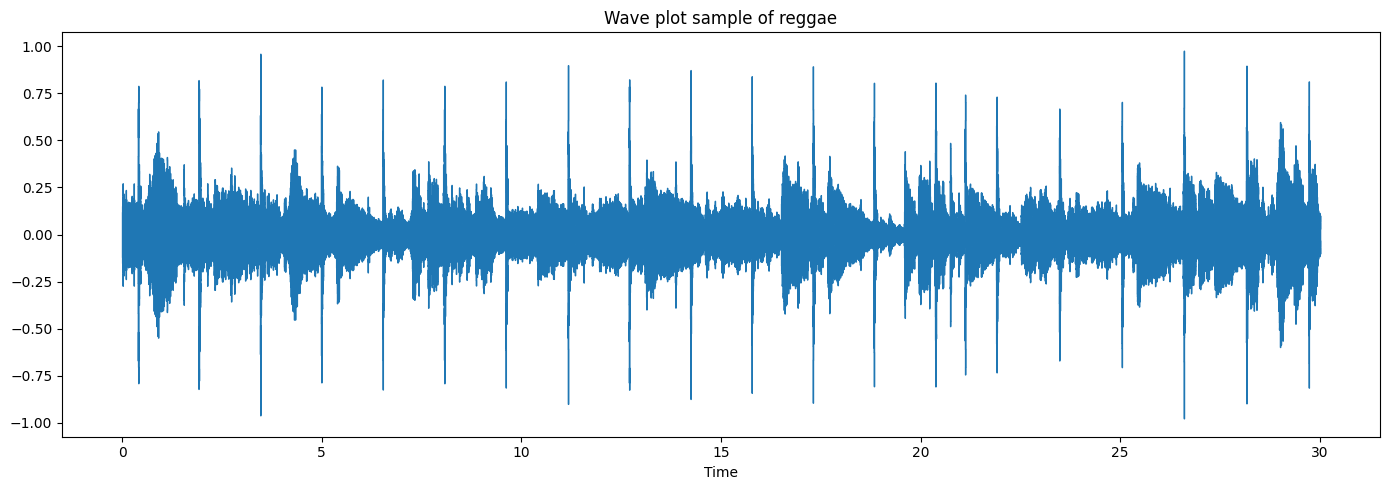

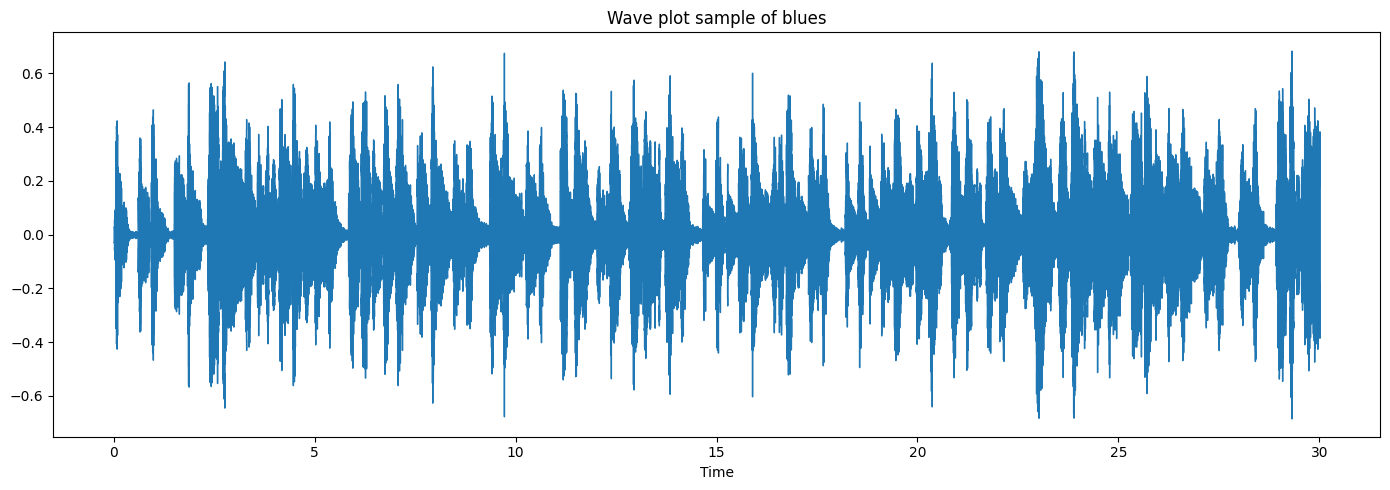

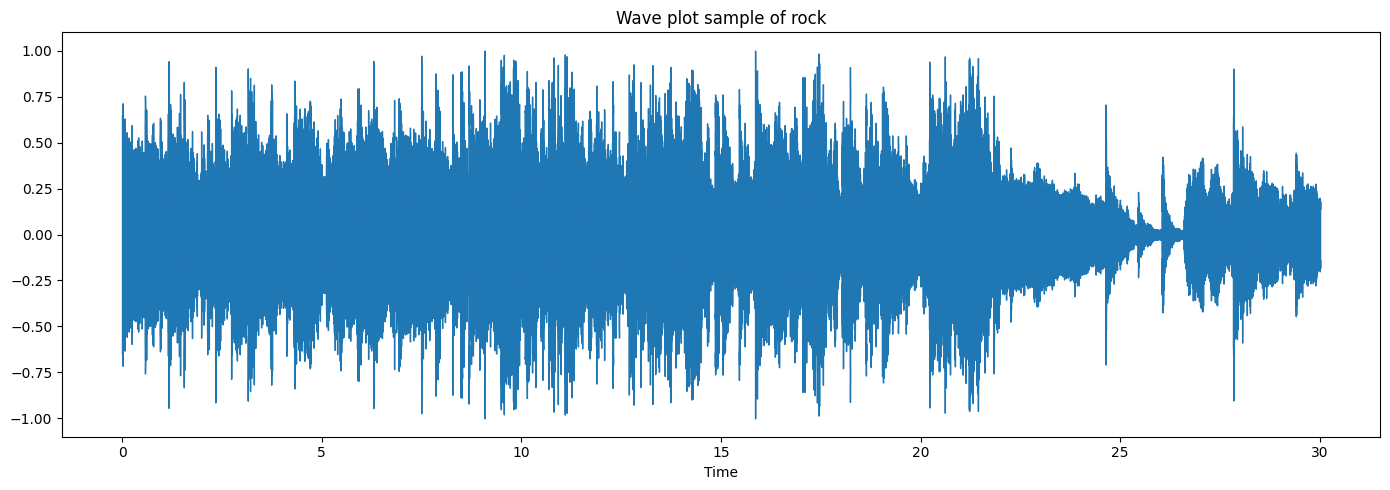

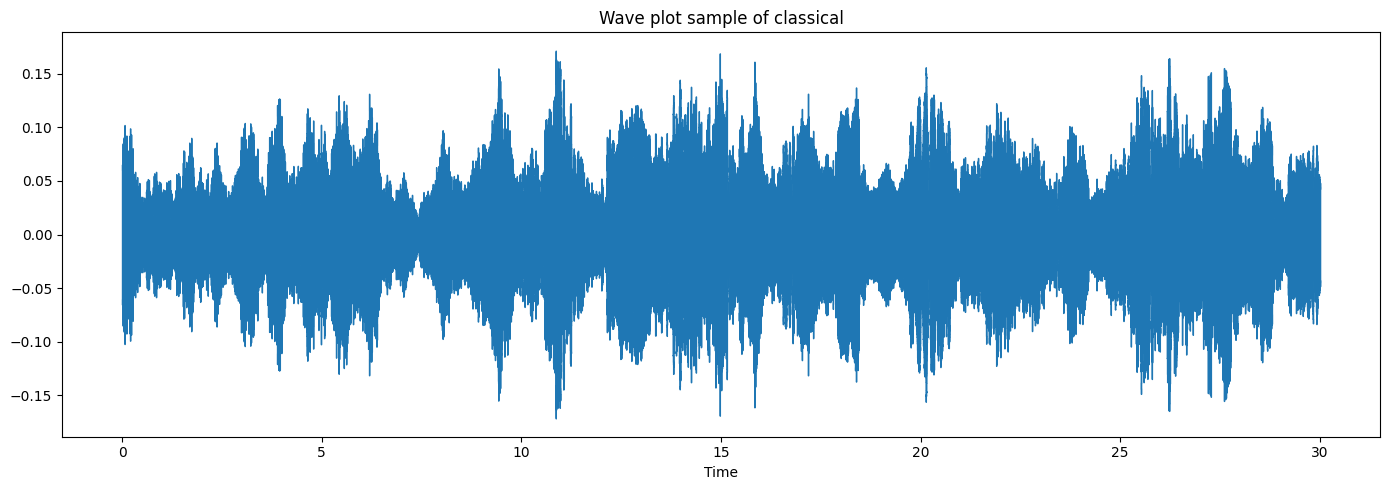

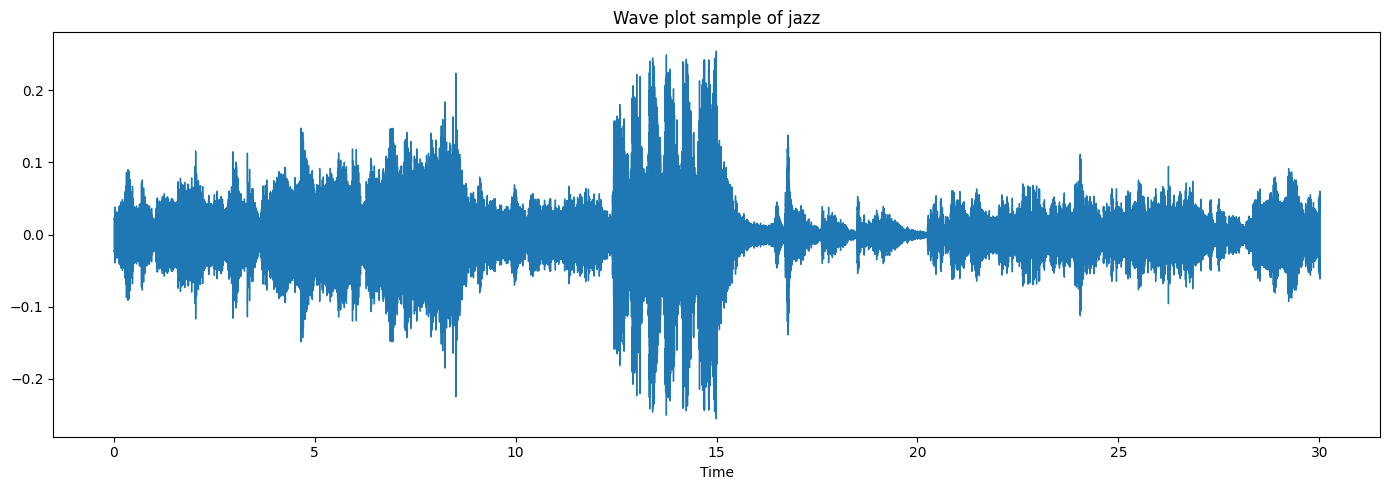

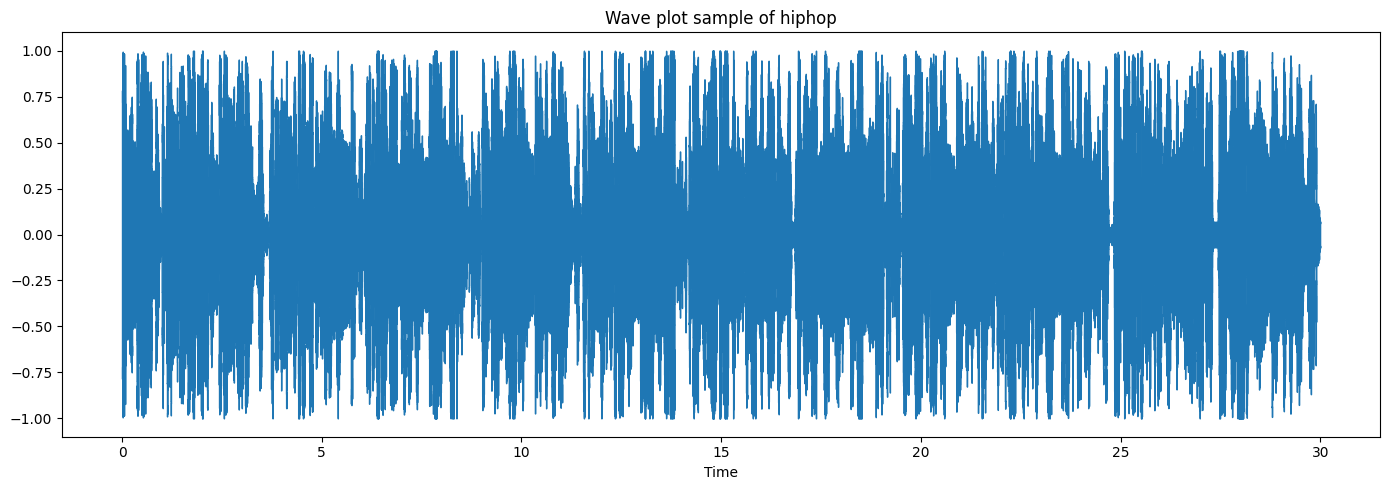

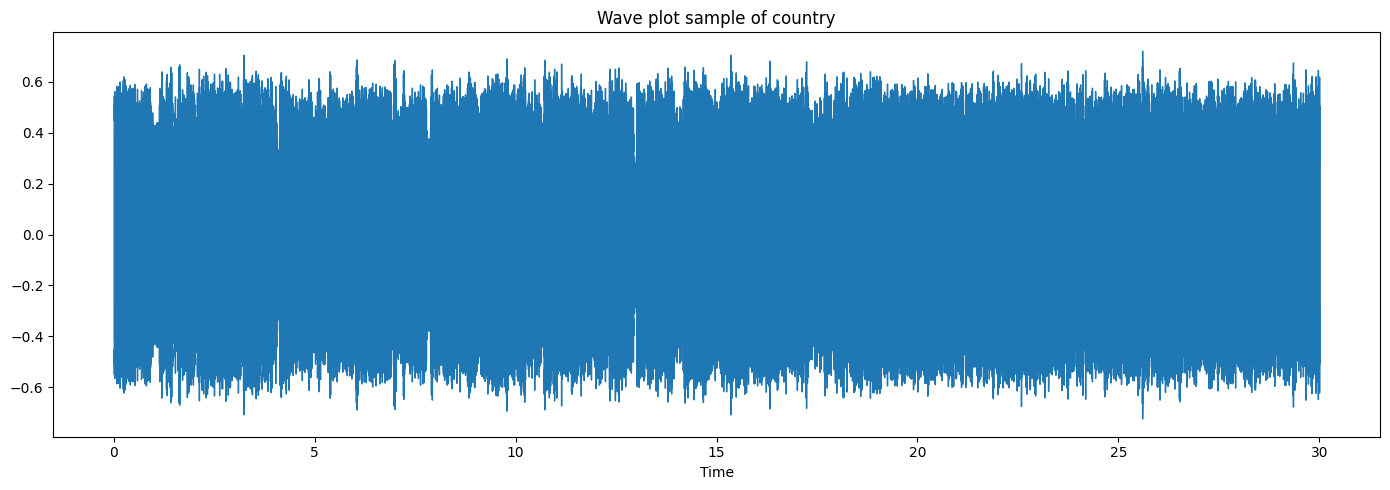

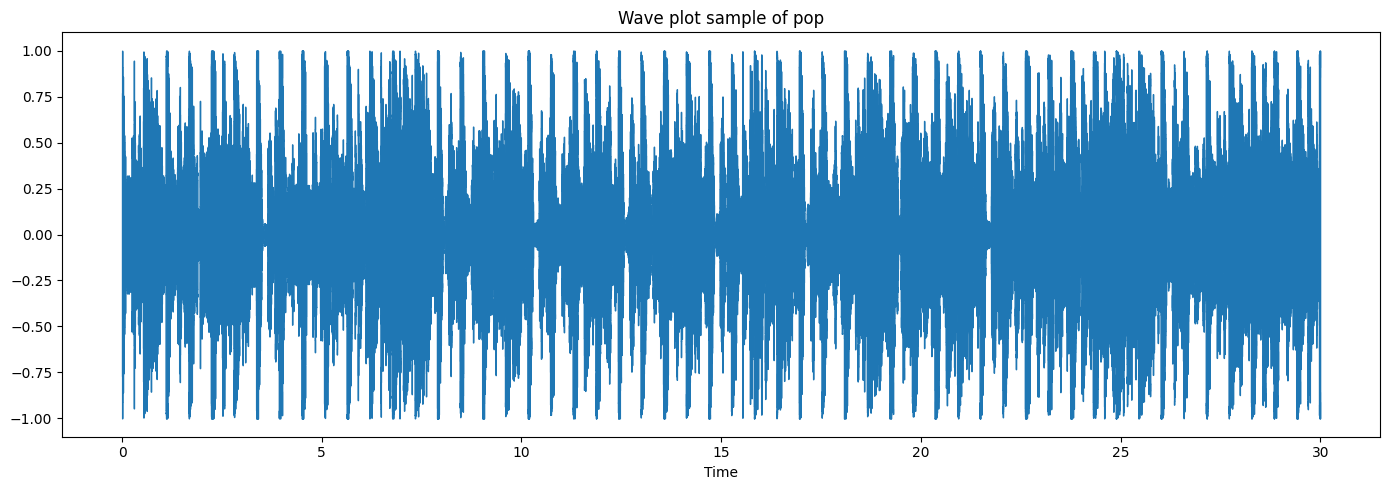

In [12]:
genres = ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']

for genre in genres:
    file_path = f'/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/{genre}/{genre}.00001.wav'
    audio, sr = librosa.load(file_path, sr=22050)  # Load with 22,050 Hz sampling rate
    plt.figure(figsize=(14, 5))
    plt.title(f'Wave plot sample of {genre}')
    librosa.display.waveshow(audio, sr=sr)
    plt.tight_layout()  # Adjust layout
    plt.show()


For this exercise, we will be using **CQT (Constant-Q Transform)**

The Constant-Q Transform (CQT) is a method for converting audio data from the time domain into the time-frequency domain. In this representation:

1. The time domain (audio waveform) consists of amplitude values that vary over time.
2. The time-frequency domain shows how the energy (amplitude or power) of the signal is distributed across different frequencies over time.
3. CQT is similar to the Short-Time Fourier Transform (STFT) or Mel Spectrogram but has some unique properties:

**Logarithmic Frequency Scaling:**

In CQT, the frequencies are spaced logistically. This means lower frequencies are more closely spaced, while higher frequencies are farther apart.
This mimics how humans perceive sound (e.g., we can differentiate low frequencies better than high frequencies).
Variable Time Resolution:

Lower frequencies have better frequency resolution but lower time resolution.
Higher frequencies have better time resolution but lower frequency resolution.
This property is especially useful for analyzing music, where pitch (frequency) is crucial.

When you compute the CQT for an audio file, you get a 2D matrix where:

- Rows: Represent frequency bins (e.g., notes or pitches in a musical scale).
- Columns: Represent time frames (segments of the audio signal over time).
- Each element in this matrix represents the energy or amplitude of a specific frequency at a specific time.

Here we generated a CQT plot for a single sample in each genre:

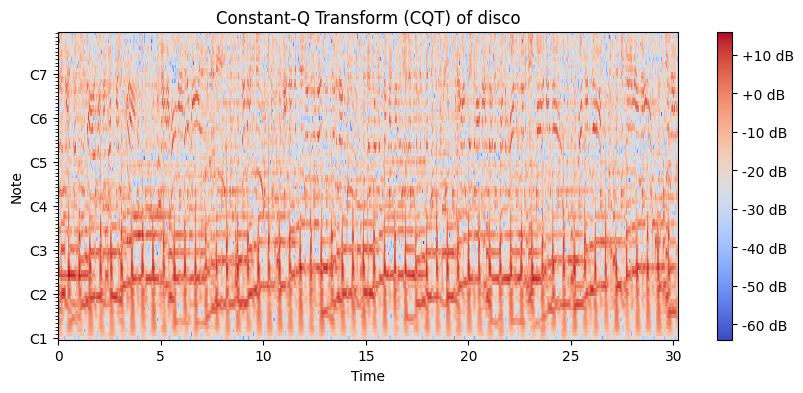

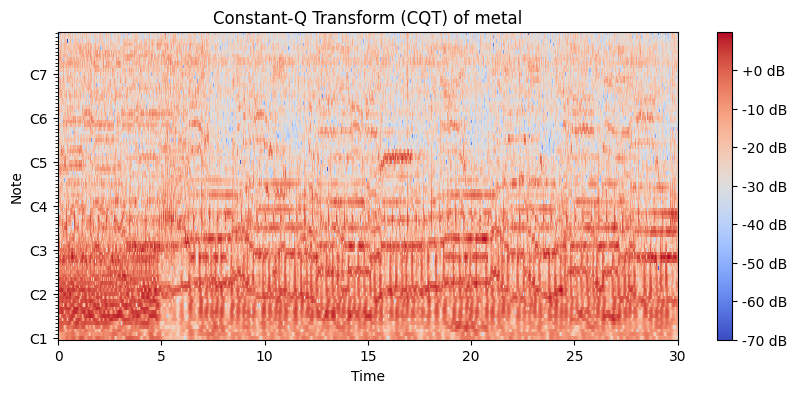

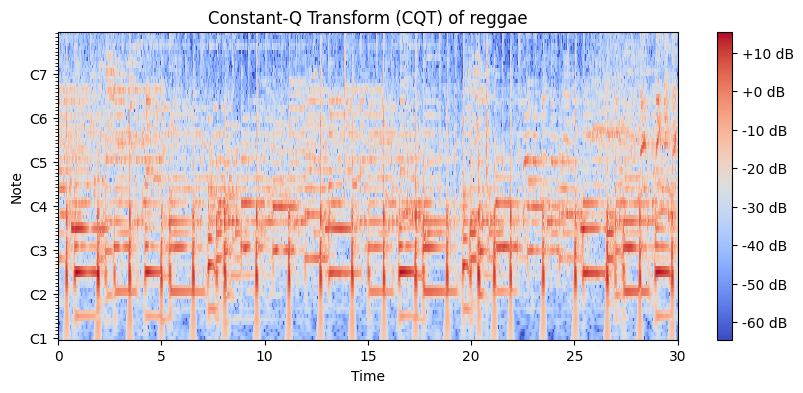

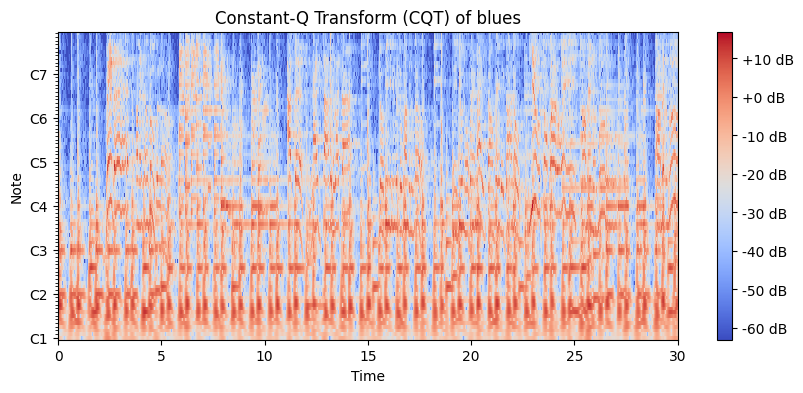

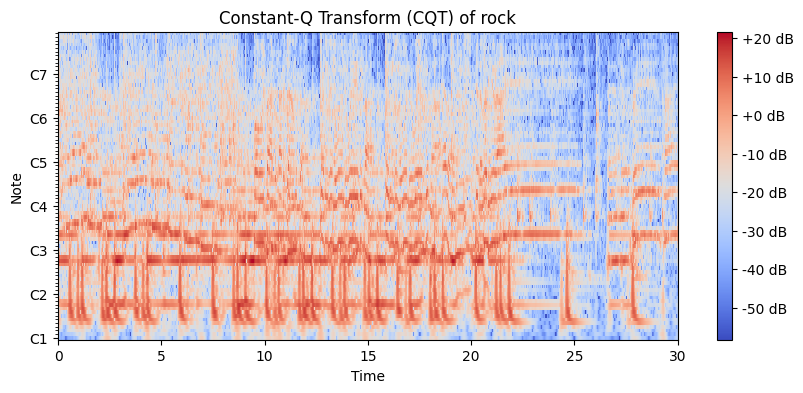

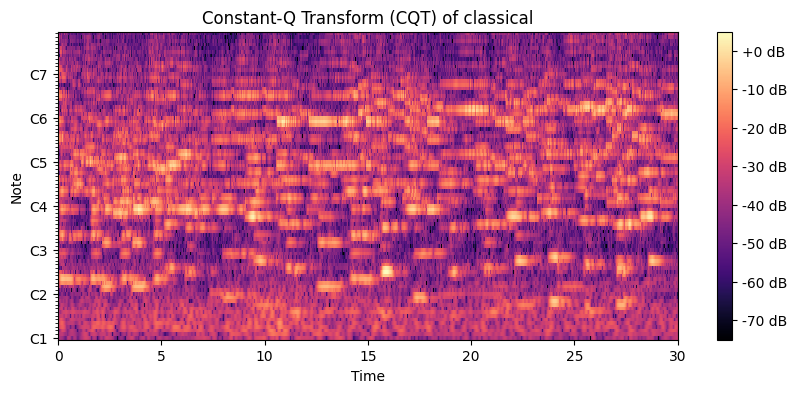

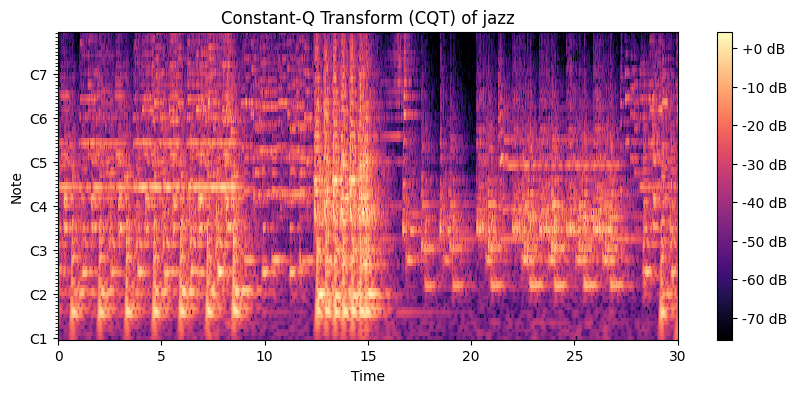

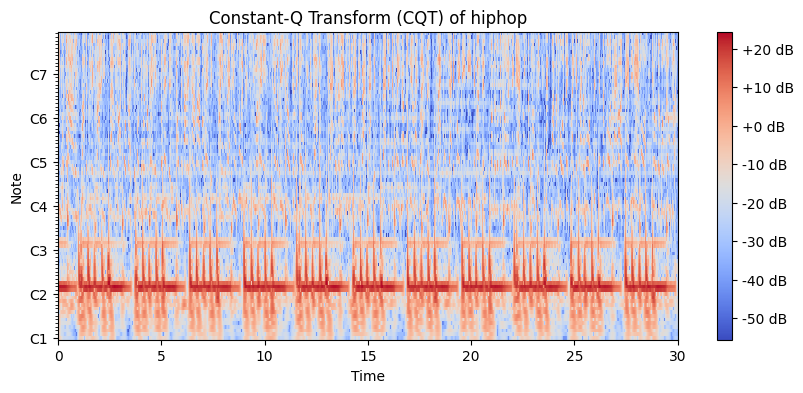

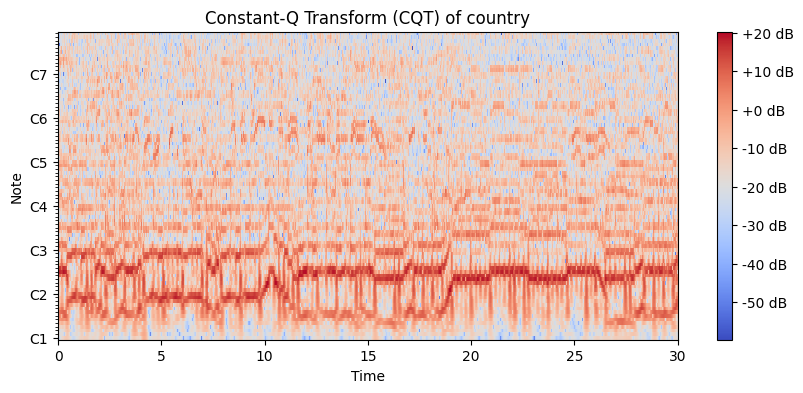

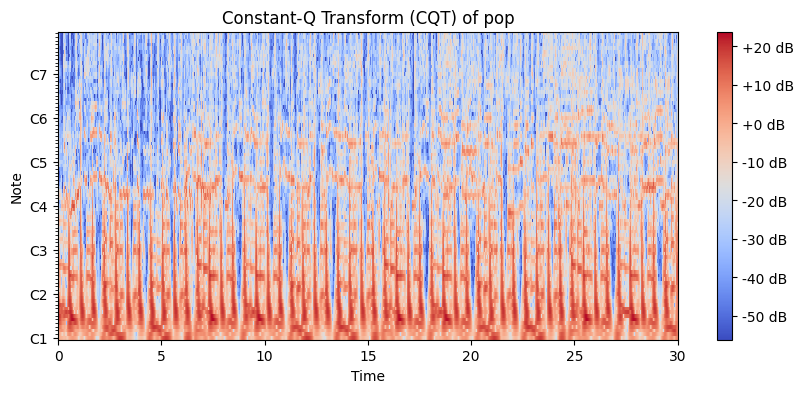

In [7]:
import librosa
import matplotlib.pyplot as plt
from librosa.display import specshow

for genre in genres:
    file_path = f'/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/{genre}/{genre}.00001.wav'
    audio, sr = librosa.load(file_path, sr=22050)  # Load with 22,050 Hz sampling rate

    # Example: Compute CQT
    cqt = librosa.cqt(audio, sr=sr, n_bins=84, bins_per_octave=12)
    
    # Convert the CQT to decibels for better visualization
    log_cqt = librosa.amplitude_to_db(abs(cqt))
    
    # Visualize the CQT
    plt.figure(figsize=(10, 4))
    specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', bins_per_octave=12)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Constant-Q Transform (CQT) of {genre}')
    plt.show()


In order to get the features we are going to use for the project, we need to be sure that every file in the dataset works correctly and is not corrupted. Here we validated this loading each audio with librosa; when librosa was able to load the audio without problems, the audio was valid; when there was a problem loading the audio, this audio is corrupted and must not be considered for the present exercise.

In [8]:
import os
import librosa

# Initialize a list to keep track of corrupted files
corrupted_files = []

# Iterate through each genre folder
for genre in os.listdir(dataset_path):
    genre_path = os.path.join(dataset_path, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file)
            try:
                # Attempt to load the audio file
                librosa.load(file_path, sr=None)
            except Exception as e:
                print(f"Corrupted file detected: {file_path}")
                corrupted_files.append(file_path)

/tmp/ipykernel_177/2179971151.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.load(file_path, sr=None)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Corrupted file detected: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav


We found that the audio 00054 in the jazz folder is corrupted, so we defined a list of the valid files, skipping this file that is not working properly.

In [4]:
import os
import librosa

dataset_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
corrupted_file = os.path.join(dataset_path, 'jazz/jazz.00054.wav')  # Known corrupted file

valid_files = []

for genre in os.listdir(dataset_path):
    genre_path = os.path.join(dataset_path, genre)
    for file_name in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file_name)
        if file_path == corrupted_file:
            print(f"Skipping corrupted file: {file_path}")
            continue
        valid_files.append(file_path)

print(f"Total valid files: {len(valid_files)}")


Skipping corrupted file: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav
Total valid files: 999


To be sure our classes are balanced, we plotted the valid files for each genre, finding that in general terms (besides jazz that has one less song), classes are balanced.

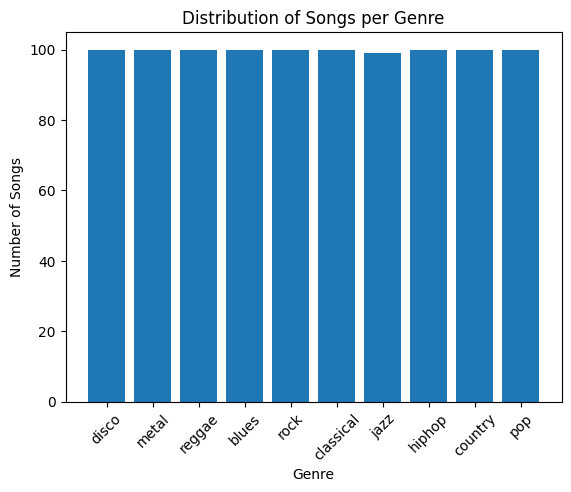

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

genre_counts = Counter([os.path.basename(os.path.dirname(f)) for f in valid_files])

# Plot the distribution
plt.bar(genre_counts.keys(), genre_counts.values())
plt.title("Distribution of Songs per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()


In [16]:
import numpy as np

for genre in genres:
    genre_indices = [i for i, label in enumerate(labels) if label == genre]
    genre_features = features[genre_indices]
    print(f"Genre: {genre}")
    print(f"Mean: {np.mean(genre_features):.2f}, Std Dev: {np.std(genre_features):.2f}")
    print("-" * 20)


Genre: disco
Mean: -18.55, Std Dev: 13.35
--------------------
Genre: metal
Mean: -15.14, Std Dev: 11.71
--------------------
Genre: reggae
Mean: -22.69, Std Dev: 15.39
--------------------
Genre: blues
Mean: -21.49, Std Dev: 15.62
--------------------
Genre: rock
Mean: -19.43, Std Dev: 13.34
--------------------
Genre: classical
Mean: -34.79, Std Dev: 15.76
--------------------
Genre: jazz
Mean: -26.08, Std Dev: 14.24
--------------------
Genre: hiphop
Mean: -19.44, Std Dev: 15.98
--------------------
Genre: country
Mean: -22.11, Std Dev: 14.58
--------------------
Genre: pop
Mean: -17.89, Std Dev: 14.89
--------------------


/tmp/ipykernel_177/3475692105.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Use 'tab20', 'Set3', or others for larger datasets


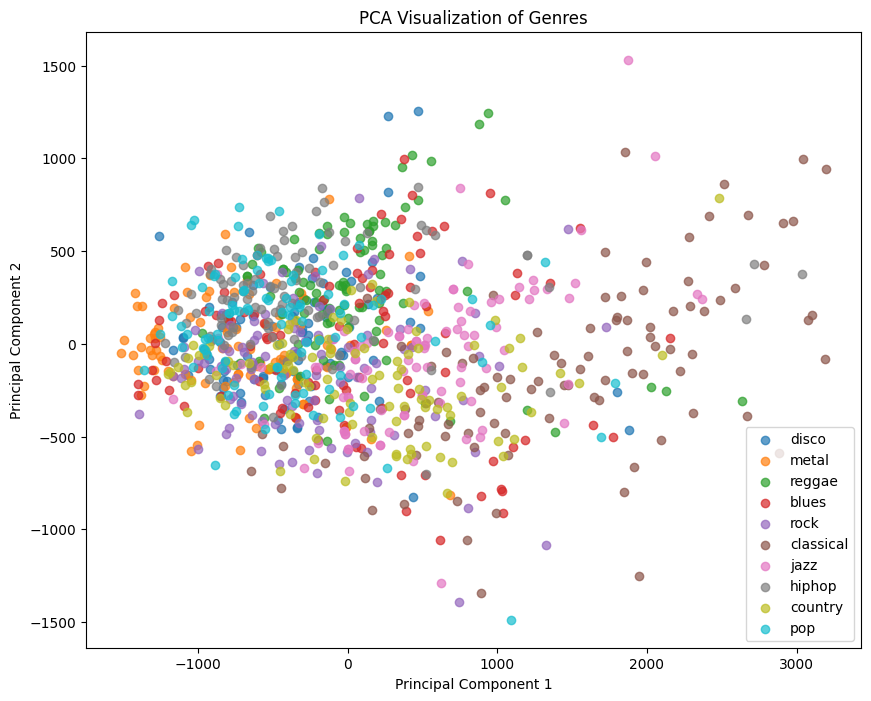

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


# Flatten the 3D feature array to 2D (samples x features)
num_samples = features.shape[0]
flattened_features = features.reshape(num_samples, -1)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(flattened_features)

cmap = get_cmap('tab20')  # Use 'tab20', 'Set3', or others for larger datasets

plt.figure(figsize=(10, 8))
for i, genre in enumerate(genres):
    indices = [j for j, label in enumerate(labels) if label == genre]
    plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1],
                label=genre, alpha=0.7, color=cmap(i / len(genres)))  # Normalize i to [0, 1]
plt.legend()
plt.title("PCA Visualization of Genres")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()



We already know that each audio has 30 seconds, but we are not sure that every audio has the exact same length considering miliseconds and so on. To understand this now we get information about the extent of the audio files, finding that there are 34 different lengths in the length of the 999 files. This could be problematic considering that all the data must have the same size.

In [15]:
import librosa

audio_lengths = []

for file_path in valid_files:
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=22050)  # Fixed sampling rate
        audio_lengths.append(len(audio))
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Check the lengths
print("Minimum length:", min(audio_lengths))
print("Maximum length:", max(audio_lengths))
print("Unique lengths:", set(audio_lengths))
print("Number of unique lengts: ", len(set(audio_lengths)))


Minimum length: 660000
Maximum length: 675808
Unique lengths: {661504, 661760, 668800, 670340, 663300, 667920, 669460, 672282, 661408, 660000, 661794, 663080, 670120, 661676, 666160, 667700, 669240, 663740, 665280, 666820, 664400, 665940, 667480, 661980, 663520, 661344, 675808, 665060, 672100, 668140, 661100, 669680, 664180, 661500}
Number of unique lengts:  34


To be sure all the audios have the same length, we are going to pad or truncate to a fixed length to set a fixed number of time steps for all CQT features:

- If an array is shorter than the target length, pad it with zeros.
- If an array is longer, truncate it to the target length.

Now that we are sure that the lengths are the same we proceed to extract the features with the function preprocess_audio_fixed_length. In this function:

- n_bins defines the total number of frequency bins in the Constant-Q Transform.Each bin corresponds to a specific frequency range.
- bins_per_octave defines how many bins (or steps) are included in each octave of the frequency spectrum. The default, 12 bins per octave, corresponds to the 12 semitones in the Western music scale.
- target_length (Fixed Length in Time Frames) specifies the number of time frames (columns) the CQT output should have. This is critical because audio clips can have different durations, leading to variable output shapes.

In [19]:
def preprocess_audio_fixed_length(file_path, sr=22050, n_bins=128, bins_per_octave=24, target_length=256):
    try:
        # Load audio
        audio, _ = librosa.load(file_path, sr=sr)
        # Compute CQT
        cqt = librosa.cqt(audio, sr=sr, n_bins=n_bins, bins_per_octave=bins_per_octave)
        log_cqt = librosa.amplitude_to_db(abs(cqt))
        
        # Pad or truncate to target_length
        if log_cqt.shape[1] < target_length:
            # Pad with zeros
            pad_width = target_length - log_cqt.shape[1]
            log_cqt = np.pad(log_cqt, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate
            log_cqt = log_cqt[:, :target_length]
        
        return log_cqt
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Process and save features for all valid files
features, labels = [], []
target_length = 128  # Adjust this based on your dataset

for file_path in valid_files:
    genre = os.path.basename(os.path.dirname(file_path))
    cqt_feature = preprocess_audio_fixed_length(file_path, target_length=target_length)
    if cqt_feature is not None:
        features.append(cqt_feature)
        labels.append(genre)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

print("Feature shape:", features.shape)
print("Labels shape:", labels.shape)


Feature shape: (999, 128, 128)
Labels shape: (999,)


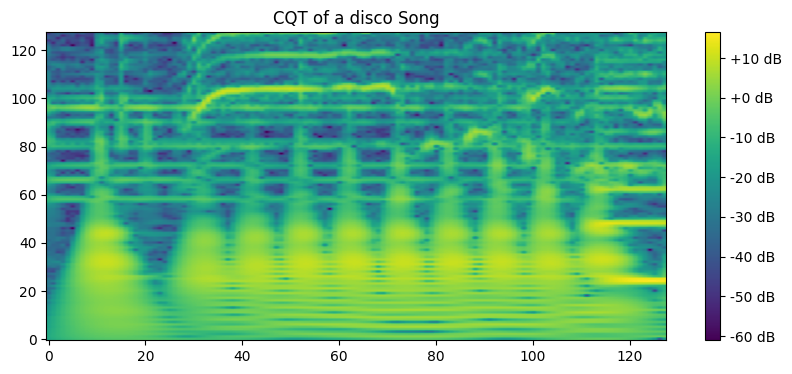

In [20]:
import random

# Pick a random feature and plot it
random_idx = random.randint(0, len(features) - 1)
sample_feature = features[random_idx]
sample_label = labels[random_idx]

plt.figure(figsize=(10, 4))
plt.title(f"CQT of a {sample_label} Song")
plt.imshow(sample_feature, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.show()


## Model building

With the features already extracted from the audios, we can proceed with the modeling part. The first part of this process is getting the training, validation, and testing datasets:

In [21]:
from sklearn.model_selection import train_test_split

# Split into training + validation and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split training into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 639
Validation set size: 160
Test set size: 200


Considering we are going to apply classical machine learning and CNN algorithms, we are defining the encoding of dependent variables, ushing the one hot labeling and the label encoding approaches.

In [22]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Reshape labels to 2D for one-hot encoding
y_train_onehot = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_onehot = one_hot_encoder.transform(np.array(y_val).reshape(-1, 1))
y_test_onehot = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))

print("One-Hot Encoded Example (Train):", y_train_onehot[0])


One-Hot Encoded Example (Train): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print("Integer Encoded Example (Train):", y_train_encoded[:5])
print("Genres corresponding to the example :", y_train[:5])


Integer Encoded Example (Train): [3 3 6 1 5]
Genres corresponding to the example : ['disco' 'disco' 'metal' 'classical' 'jazz']


### Classical Machine Learning models

First, we are going to get statistics from the data and apply them as features for classical machine learning models.

In [24]:
# Function to extract statistics
def extract_statistics(features):
    stats = []
    for feature in features:
        stats.append([
            np.mean(feature), 
            np.std(feature), 
            np.min(feature), 
            np.max(feature)
        ])
    return np.array(stats)

# Extract statistics
X_train_stats = extract_statistics(X_train)
X_val_stats = extract_statistics(X_val)
X_test_stats = extract_statistics(X_test)

print("Shape of statistical features in training dataset:", X_train_stats.shape)


Shape of statistical features in training dataset: (639, 4)


We proceed to scale the features using the standard scaler

In [27]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training, validation, and test data
X_train_stats_scaled = scaler.fit_transform(X_train_stats)
X_val_stats_scaled = scaler.transform(X_val_stats)
X_test_stats_scaled = scaler.transform(X_test_stats)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM
svm = SVC()

# GridSearchCV with scaled features
svm_grid = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=5, scoring='accuracy', verbose=2)
svm_grid.fit(X_train_stats_scaled, y_train_encoded)

# Best parameters and score
print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM Score:", svm_grid.best_score_)

#Best SVM model
svm_best=svm_grid.best_estimator_

In [29]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set with the best SVM model
y_val_pred_svm = svm_grid.best_estimator_.predict(X_val_stats_scaled)

# Test accuracy and report
print("SVM Test Accuracy:", accuracy_score(y_val_encoded, y_val_pred_svm))
print("SVM Classification Report:\n", classification_report(y_val_encoded, y_val_pred_svm))


SVM Test Accuracy: 0.375
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.19      0.25        16
           1       0.67      0.62      0.65        16
           2       0.55      0.38      0.44        16
           3       0.36      0.56      0.44        16
           4       0.33      0.06      0.11        16
           5       0.40      0.50      0.44        16
           6       0.41      0.75      0.53        16
           7       0.26      0.38      0.31        16
           8       0.24      0.25      0.24        16
           9       0.11      0.06      0.08        16

    accuracy                           0.38       160
   macro avg       0.37      0.38      0.35       160
weighted avg       0.37      0.38      0.35       160



In [ ]:
from sklearn.linear_model import LogisticRegression

# Define parameter grid for Logistic Regression
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000)

# GridSearchCV with scaled features
logreg_grid = GridSearchCV(estimator=logreg, param_grid=logreg_param_grid, cv=5, scoring='accuracy', verbose=2)
logreg_grid.fit(X_train_stats_scaled, y_train_encoded)

# Best parameters and score
print("Best Logistic Regression Parameters:", logreg_grid.best_params_)
print("Best Logistic Regression Score:", logreg_grid.best_score_)

# Best logistic regression model
logreg_best = logreg_grid.best_estimator_


In [47]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set with the best SVM model
y_val_pred_logreg = logreg_best.predict(X_val_stats_scaled)

# Test accuracy and report
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val_encoded, y_val_pred_logreg))
print("Logistic Regression Classification Report:\n", classification_report(y_val_encoded, y_val_pred_logreg))


Logistic Regression Validation Accuracy: 0.375
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.19      0.29        16
           1       0.56      0.62      0.59        16
           2       0.60      0.38      0.46        16
           3       0.44      0.50      0.47        16
           4       0.46      0.38      0.41        16
           5       0.23      0.19      0.21        16
           6       0.39      0.69      0.50        16
           7       0.26      0.38      0.31        16
           8       0.25      0.31      0.28        16
           9       0.17      0.12      0.14        16

    accuracy                           0.38       160
   macro avg       0.40      0.38      0.37       160
weighted avg       0.40      0.38      0.37       160



In [48]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]         # Minimum samples in a leaf
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train_stats_scaled, y_train_encoded)  

# Best model
rf_best=rf_grid.best_estimator_

In [50]:
# Best parameters and score
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest Cross-Validation Accuracy:", rf_grid.best_score_)

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Random Forest Cross-Validation Accuracy: 0.3803272637795275


In [51]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set with the best RF model
y_val_pred_rf = rf_best.predict(X_val_stats_scaled)

# Test accuracy and report
print("Random forest Validation Accuracy:", accuracy_score(y_val_encoded, y_val_pred_rf))
print("Random forest Classification Report:\n", classification_report(y_val_encoded, y_val_pred_rf))


Random forest Validation Accuracy: 0.38125
Random forest Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.19      0.27        16
           1       0.53      0.56      0.55        16
           2       0.38      0.31      0.34        16
           3       0.38      0.38      0.38        16
           4       0.50      0.56      0.53        16
           5       0.21      0.31      0.25        16
           6       0.54      0.81      0.65        16
           7       0.40      0.38      0.39        16
           8       0.20      0.19      0.19        16
           9       0.17      0.12      0.14        16

    accuracy                           0.38       160
   macro avg       0.38      0.38      0.37       160
weighted avg       0.38      0.38      0.37       160



In [52]:
from xgboost import XGBClassifier

# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],        # Number of boosting rounds
    'max_depth': [3, 6, 10],               # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    'subsample': [0.8, 1.0],               # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0]         # Fraction of features used per tree
}

# Initialize XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Perform GridSearchCV
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
xgb_grid.fit(X_train_stats, y_train_encoded)  # Use scaled features if needed for other models

# Best parameters and score
print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost Cross-Validation Accuracy:", xgb_grid.best_score_)

# Best XGBoost model
xgb_best=xgb_grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Cross-Validation Accuracy: 0.4006520669291339


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set with the best RF model
y_val_pred_xgb = xgb_best.predict(X_val_stats_scaled)

# Test accuracy and report
print("XGBoost Validation Accuracy:", accuracy_score(y_val_encoded, y_val_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_val_encoded, y_val_pred_xgb))


### CNN for genre classification

First we make different sequential models to predict generes

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler_cnn = MinMaxScaler()

# Flatten features for scaling
num_samples_train, height, width = X_train.shape
num_samples_val, _, _ = X_val.shape
num_samples_test, _, _ = X_test.shape

X_train_flattened = X_train.reshape(num_samples_train, -1)
X_val_flattened = X_val.reshape(num_samples_val, -1)
X_test_flattened = X_test.reshape(num_samples_test, -1)

# Fit scaler_cnn on training data and transform all datasets
X_train_scaled = scaler_cnn.fit_transform(X_train_flattened)
X_val_scaled = scaler_cnn.transform(X_val_flattened)
X_test_scaled = scaler_cnn.transform(X_test_flattened)

# Reshape back to original dimensions with channel dimension added
X_train_cnn = X_train_scaled.reshape(num_samples_train, height, width, 1)
X_val_cnn = X_val_scaled.reshape(num_samples_val, height, width, 1)
X_test_cnn = X_test_scaled.reshape(num_samples_test, height, width, 1)

print("Scaled and reshaped training data shape:", X_train_cnn.shape)
print("Scaled and reshaped validation data shape:", X_val_cnn.shape)
print("Scaled and reshaped test data shape:", X_test_cnn.shape)


Scaled and reshaped training data shape: (639, 128, 128, 1)
Scaled and reshaped validation data shape: (160, 128, 128, 1)
Scaled and reshaped test data shape: (200, 128, 128, 1)


In [18]:
from tensorflow.keras import layers, models

# Define the CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),  # (height, width, channels)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(len(genres), activation='softmax')  # Output layer
])

cnn_model.compile(optimizer='adamW',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 82, 126, 128)   │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 41, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 39, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 19, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 17, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 14, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,706 (2.11 MB)

 Trainable params: 553,706 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(
    X_train_cnn, y_train_onehot, 
    validation_data=(X_val_cnn, y_val_onehot), 
    epochs=100, batch_size=32
)


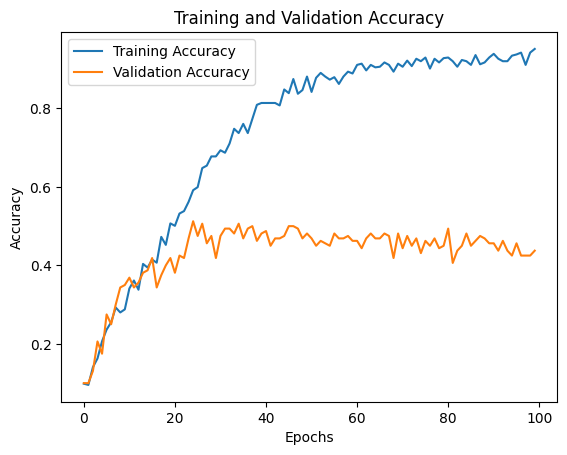

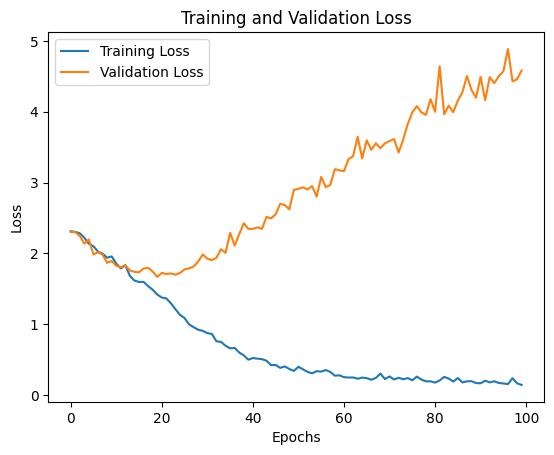

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Now we make a different approach to include data augmentation

In [30]:
from tensorflow.keras import layers, models

# Define the CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),  # (height, width, channels)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(len(genres), activation='softmax')  # Output layer
])

cnn_model.compile(optimizer='adamW',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 82, 126, 128)   │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 41, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 39, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 19, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 17, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 8, 14, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,706 (2.11 MB)

 Trainable params: 553,706 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Fit the data generator on the training data
datagen.fit(X_train_cnn)

# Train the CNN with data augmentation
history_aug = cnn_model.fit(
    datagen.flow(X_train_cnn, y_train_onehot, batch_size=32),
    validation_data=(X_val_cnn, y_val_onehot),
    epochs=200
)


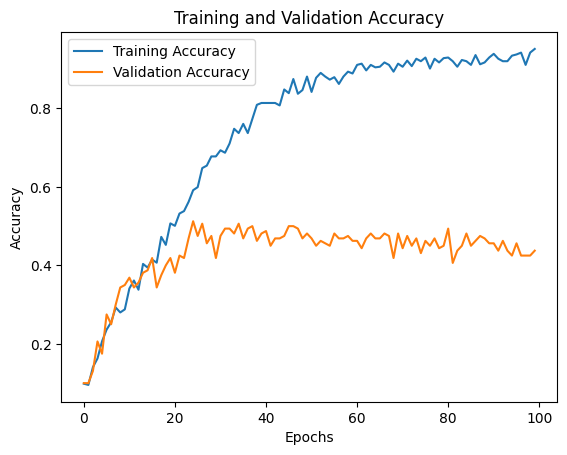

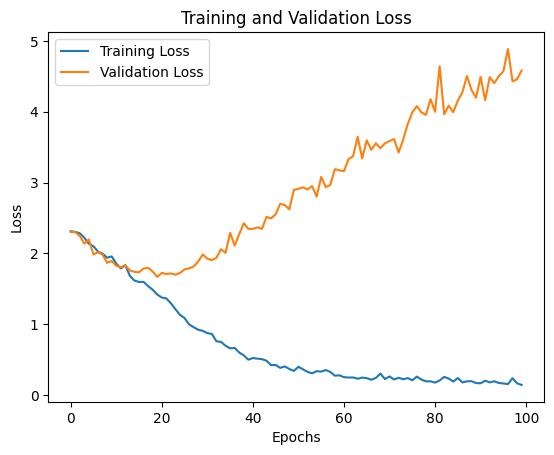

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Finally, we tried a more robust model with more layers and parameters.

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),  # (height, width, channels)
    layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(len(genres), activation='softmax')  # Output layer
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


In [ ]:
history = cnn_model.fit(
    X_train_cnn, y_train_onehot, 
    validation_data=(X_val_cnn, y_val_onehot), 
    epochs=100, batch_size=32
)


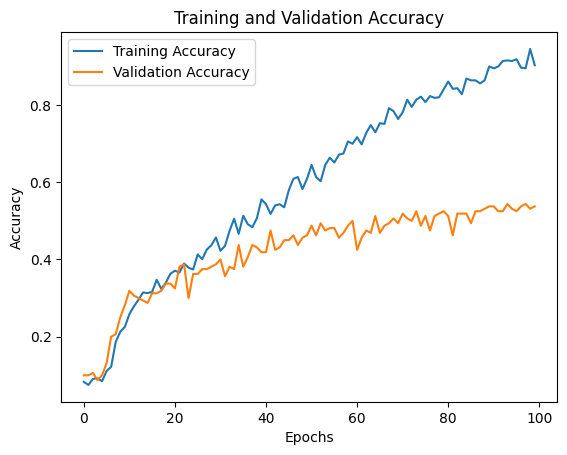

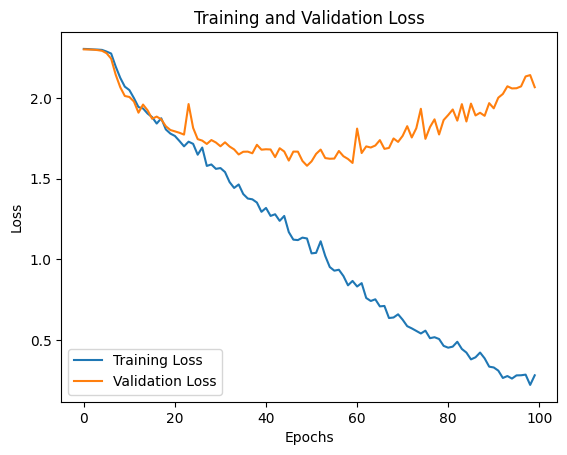

In [44]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [36]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),  # (height, width, channels)
    layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1200, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(genres), activation='softmax')  # Output layer
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(
    X_train_cnn, y_train_onehot, 
    validation_data=(X_val_cnn, y_val_onehot), 
    epochs=100, batch_size=32
)

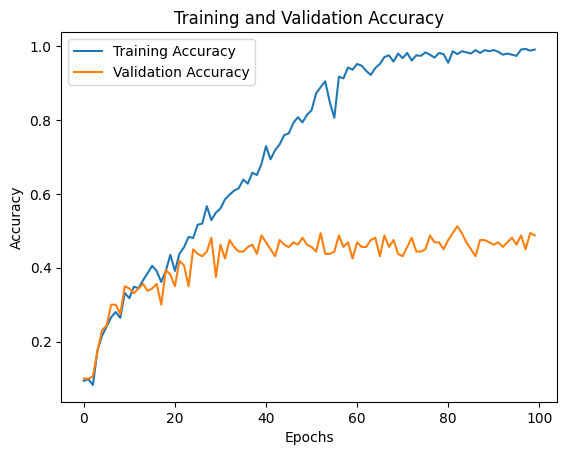

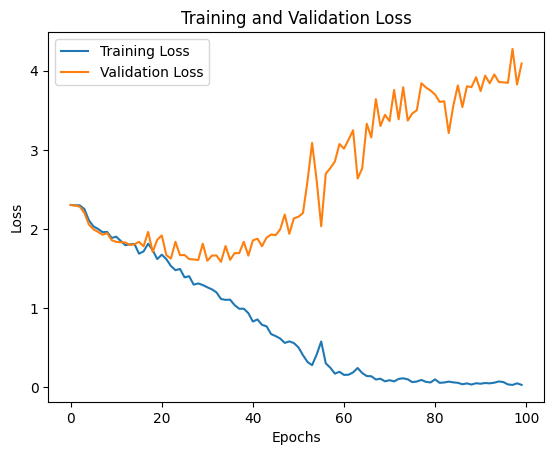

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Despite of the different approaches and model configurations, we are getting poor performance, so we decide to implement Mel Spectograms to feed the model for predictions.

### Mel spectograms

We decided to take another approach and istead of generating one figure per song, we devided each audio file into 4-second chunks with a 2-second overlap, ensuring more data points are extracted from each file.

This approach avoids losing information from long audio files by processing smaller, uniform pieces.

Mel spectrograms are computed for each chunk and resized to a fixed target shape, ensuring consistent input dimensions for the CNN.

By processing overlapping chunks, the dataset effectively increases in size, which enhances generalization and helps reduce overfitting. Here we are implementing data augmentation

We use an architecture similar to the last attempt that includes Dropout for regularization, which improves generalization on the validation set.


In [54]:
import os
import librosa
import numpy as np
from tensorflow.image import resize

# Define genres
genres = ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']

# Base path to dataset
base_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/'

# Corrupted file to skip
corrupted_file = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav'

# Initialize features and labels
features = []
labels = []

def process_audio_chunks(file_path, sr=22050, chunk_duration=4, overlap_duration=2, target_shape=(150, 150)):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=sr)
        
        # Convert durations to samples
        chunk_samples = int(chunk_duration * sample_rate)
        overlap_samples = int(overlap_duration * sample_rate)
        
        # Calculate the number of chunks
        num_chunks = int(np.ceil((len(audio) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
        
        # Initialize a list for chunks
        spectrograms = []
        
        # Process each chunk
        for i in range(num_chunks):
            start = i * (chunk_samples - overlap_samples)
            end = start + chunk_samples
            chunk = audio[start:end]

            # Ensure the chunk has enough samples
            if len(chunk) < chunk_samples:
                continue
            
            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate, n_mels=128, fmax=8000)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Resize to the target shape
            mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
            spectrograms.append(mel_spectrogram)
        
        return spectrograms
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return []

# Process the dataset
for genre in genres:
    genre_path = os.path.join(base_path, genre)
    for file_name in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file_name)

        # Skip the corrupted file
        if file_path == corrupted_file:
            print(f"Skipping corrupted file: {file_path}")
            continue

        # Process audio chunks and generate features
        mel_chunks = process_audio_chunks(file_path)
        features.extend(mel_chunks)
        labels.extend([genre] * len(mel_chunks))  # Replicate label for all chunks

# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Skipping corrupted file: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav
Features shape: (13977, 150, 150, 1)
Labels shape: (13977,)


Once we get the features, we proceed to split the data in training, validation and testing sets.

In [56]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (8944, 150, 150, 1) (8944,)
Validation set shape: (2237, 150, 150, 1) (2237,)
Test set shape: (2796, 150, 150, 1) (2796,)


Next, we proceed to scale the training data and transform the validation and testing datasets with the scaler.

In [61]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Flatten the features for scaling
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Fit the scaler on the training set and transform all datasets
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reshape back to original dimensions
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

print("Scaled training data shape:", X_train_scaled.shape)
print("Scaled validation data shape:", X_val_scaled.shape)
print("Scaled test data shape:", X_test_scaled.shape)


Scaled training data shape: (8944, 150, 150, 1)
Scaled validation data shape: (2237, 150, 150, 1)
Scaled test data shape: (2796, 150, 150, 1)


Given that we have a multiclass classification problem, we encoded the 10 different categories of the dependent variable using one hot encoding.

In [57]:
from tensorflow.keras.utils import to_categorical

# Unique genres (classes)
unique_genres = np.unique(labels)

# Map genres to indices
genre_to_index = {genre: idx for idx, genre in enumerate(unique_genres)}

# Encode the training, validation, and test labels
y_train_encoded = np.array([genre_to_index[label] for label in y_train])
y_val_encoded = np.array([genre_to_index[label] for label in y_val])
y_test_encoded = np.array([genre_to_index[label] for label in y_test])

# Convert to one-hot
y_train_onehot = to_categorical(y_train_encoded, num_classes=len(unique_genres))
y_val_onehot = to_categorical(y_val_encoded, num_classes=len(unique_genres))
y_test_onehot = to_categorical(y_test_encoded, num_classes=len(unique_genres))

print("One-hot encoded training labels shape:", y_train_onehot.shape)
print("One-hot encoded validation labels shape:", y_val_onehot.shape)
print("One-hot encoded test labels shape:", y_test_onehot.shape)


One-hot encoded training labels shape: (8944, 10)
One-hot encoded validation labels shape: (2237, 10)
One-hot encoded test labels shape: (2796, 10)


Now we take the first approach

In [58]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2], 1)),  # Add channel dimension
    layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1200, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(genres), activation='softmax')  # Output layer
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_82 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = cnn_model.fit(
    X_train_scaled[..., np.newaxis], y_train_onehot,  # Add channel dimension
    validation_data=(X_val_scaled[..., np.newaxis], y_val_onehot),
    epochs=30, batch_size=32
)

Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 50s 123ms/step - accuracy: 0.1243 - loss: 2.2461 - val_accuracy: 0.3138 - val_loss: 1.8789
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.3323 - loss: 1.8356 - val_accuracy: 0.3920 - val_loss: 1.6763
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.4188 - loss: 1.6413 - val_accuracy: 0.5127 - val_loss: 1.3866
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.4898 - loss: 1.4235 - val_accuracy: 0.5793 - val_loss: 1.1866
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.5489 - loss: 1.2555 - val_accuracy: 0.5811 - val_loss: 1.1806
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.5868 - loss: 1.1572 - val_accuracy: 0.5802 - val_loss: 1.2335
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.6206 - loss: 1.0733 - val_accuracy: 0.6071 - val_loss: 1.0759
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.6482 - loss: 0.9928 -

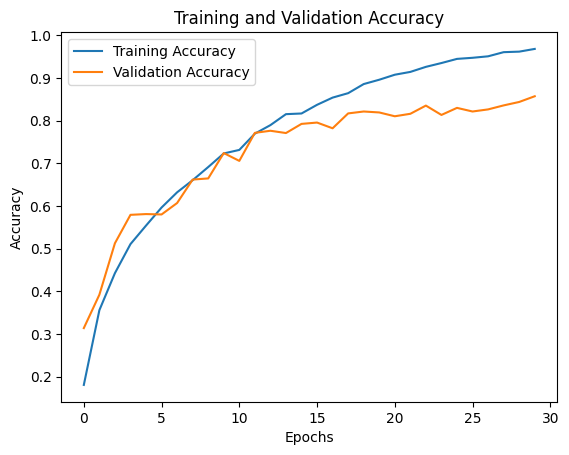

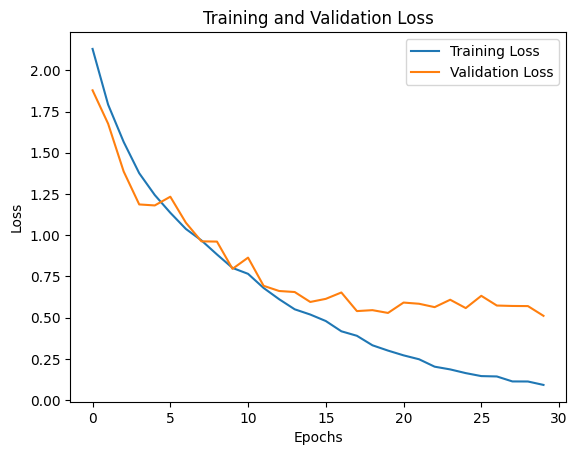

In [64]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


We save the model

In [66]:
cnn_model.save("music_genre_model.keras")


In a second approach, we include model checkpoints that allow us to save the model with the best performance.

In [72]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2], 1)),  # Add channel dimension
    layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1200, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(genres), activation='softmax')  # Output layer
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_112 (Conv2D)             │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',               # File path to save the model
    monitor='val_accuracy',                 # Metric to monitor
    save_best_only=True,                    # Save only the best model
    mode='max',                             # 'max' because we want to maximize accuracy
    verbose=1                               # Print a message when saving the model
)

# Train the model with the checkpoint callback
history = cnn_model.fit(
    X_train_scaled[..., np.newaxis], y_train_onehot,
    validation_data=(X_val_scaled[..., np.newaxis], y_val_onehot),
    epochs=50, batch_size=32,
    callbacks=[checkpoint_callback]         # Add the callback here
)


Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1167 - loss: 2.2821
Epoch 1: val_accuracy improved from -inf to 0.24005, saving model to best_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.1169 - loss: 2.2819 - val_accuracy: 0.2401 - val_loss: 2.0178
Epoch 2/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2563 - loss: 1.9841
Epoch 2: val_accuracy improved from 0.24005 to 0.39517, saving model to best_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.2566 - loss: 1.9836 - val_accuracy: 0.3952 - val_loss: 1.6976
Epoch 3/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3680 - loss: 1.7128
Epoch 3: val_accuracy improved from 0.39517 to 0.47519, saving model to best_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.3682 - loss: 1.7124 - val_accuracy: 0.4752 - val_loss: 1.4860
Epoch 4/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4666 - loss: 1.4912
Epoch 4: val_accuracy improved 

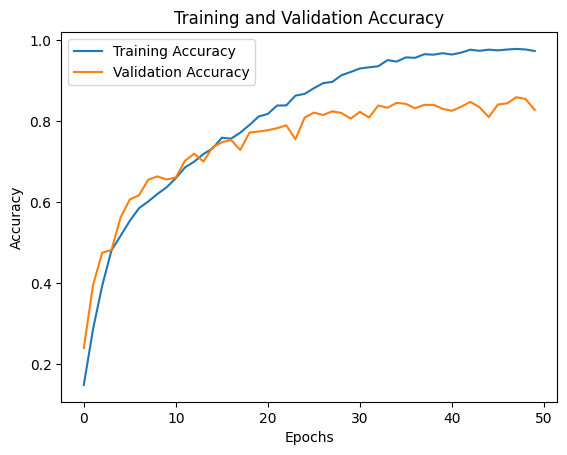

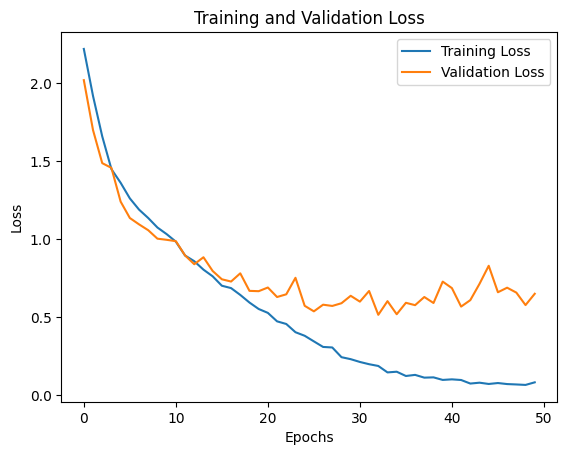

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Now we test both models with the test dataset

In [76]:
from tensorflow.keras.models import load_model

# Load the best saved model
model1 = load_model('music_genre_model.keras')
model2 = load_model('best_model.keras')


In [77]:
# Evaluate on the test dataset
test_loss, test_accuracy = model1.evaluate(X_test_scaled[..., np.newaxis], y_test_onehot, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8529 - loss: 0.5536
Test Loss: 0.5620
Test Accuracy: 0.8487


In [78]:
# Evaluate on the test dataset
test_loss, test_accuracy = model2.evaluate(X_test_scaled[..., np.newaxis], y_test_onehot, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8455 - loss: 0.6292
Test Loss: 0.6330
Test Accuracy: 0.8498


We are getting practically the same performance for both models, so we keep model1 which has less test loss

In [80]:
# Generate predictions
y_test_pred = model1.predict(X_test_scaled[..., np.newaxis])

# Convert predictions from probabilities to class indices
y_test_pred_classes = y_test_pred.argmax(axis=1)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [81]:
import numpy as np

# Convert true labels from one-hot encoding to class indices
y_test_true_classes = np.argmax(y_test_onehot, axis=1)

# Print a comparison of predicted and true labels
for i in range(10):  # Compare the first 10 samples
    print(f"True Label: {y_test_true_classes[i]}, Predicted Label: {y_test_pred_classes[i]}")


True Label: 2, Predicted Label: 2
True Label: 9, Predicted Label: 9
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 6, Predicted Label: 6
True Label: 5, Predicted Label: 5
True Label: 4, Predicted Label: 4
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 5, Predicted Label: 5


In [82]:
from sklearn.metrics import classification_report

# Get class names (genres)
class_names = np.unique(labels)

# Print a detailed classification report
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=class_names))


              precision    recall  f1-score   support

       blues       0.89      0.86      0.87       280
   classical       0.88      0.97      0.92       280
     country       0.84      0.78      0.81       279
       disco       0.77      0.87      0.82       280
      hiphop       0.86      0.86      0.86       280
        jazz       0.92      0.86      0.89       277
       metal       0.92      0.92      0.92       280
         pop       0.82      0.81      0.81       280
      reggae       0.92      0.85      0.88       280
        rock       0.69      0.72      0.70       280

    accuracy                           0.85      2796
   macro avg       0.85      0.85      0.85      2796
weighted avg       0.85      0.85      0.85      2796



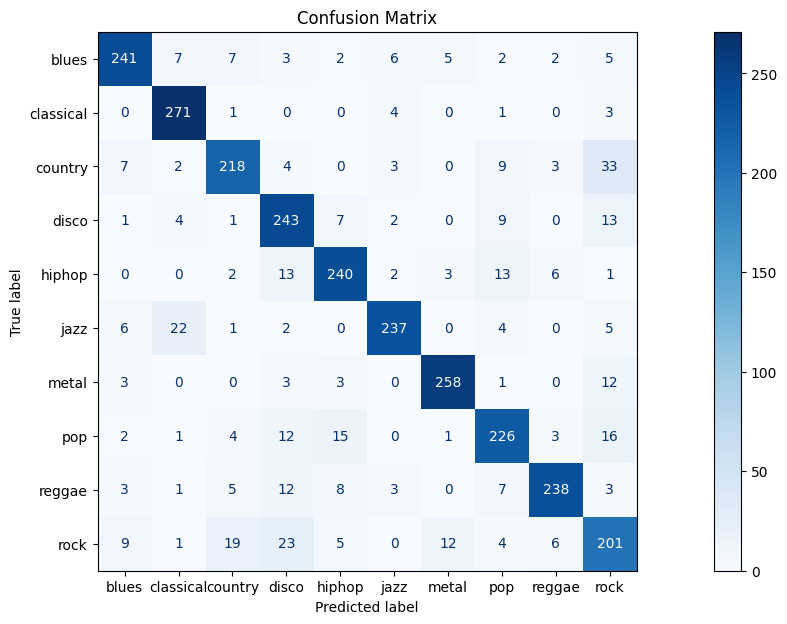

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Adjust the figure size
plt.figure(figsize=(20, 7))  # Set the desired figure size (width, height in inches)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Use the current axis (from plt.figure)

# Add title and show
plt.title('Confusion Matrix')
plt.show()


In [102]:
import pickle

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

## Making inferences

Finally, we define code to make inference over one single song so we can do that in the UI.

In [103]:
from tensorflow.keras.models import load_model

model = load_model('music_genre_model.keras')

In [104]:
import librosa
from tensorflow.image import resize
import numpy as np

def process_audio_for_inference(file_path, sr=22050, chunk_duration=4, overlap_duration=2, target_shape=(150, 150)):
    audio, _ = librosa.load(file_path, sr=sr)
    chunk_samples = int(chunk_duration * sr)
    overlap_samples = int(overlap_duration * sr)
    
    num_chunks = int(np.ceil((len(audio) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
    spectrograms = []

    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
        chunk = audio[start:end]

        if len(chunk) < chunk_samples:
            continue
        
        # Compute Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=128, fmax=8000)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Resize to match training dimensions
        mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
        spectrograms.append(mel_spectrogram)

    return np.array(spectrograms)


In [106]:
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [111]:
def predict_genre(file_path, model, label_mapping, sr=22050, chunk_duration=4, overlap_duration=2, target_shape=(150, 150)):
    # Process the input audio
    spectrograms = process_audio_for_inference(file_path, sr, chunk_duration, overlap_duration, target_shape)
    
    if spectrograms.size == 0:
        return "Error: Unable to process audio file."
    
    # Normalize the input as done during training
    spectrograms_flat = spectrograms.reshape(spectrograms.shape[0], -1)
    spectrograms_scaled = scaler.transform(spectrograms_flat)
    spectrograms_scaled = spectrograms_scaled.reshape(spectrograms.shape)
    
    # Add the channel dimension
    spectrograms_scaled = spectrograms_scaled[..., np.newaxis]

    # Predict
    predictions = model.predict(spectrograms_scaled)
    predicted_classes = predictions.argmax(axis=1)
    
    # Map indices to genre labels
    index_to_label = {index: label for label, index in label_mapping.items()}
    predicted_genres = [index_to_label[class_idx] for class_idx in predicted_classes]
    
    # Return the most frequent predicted genre (mode)
    return max(set(predicted_genres), key=predicted_genres.count)


In [110]:
genres
unique_genres
genre_to_index

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [117]:

# Define the label mapping
label_mapping = {
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9
}

# Path to a new audio file
audio_file = '/kaggle/input/sample/Adagio.mp3'

# Predict the genre
predicted_genre = predict_genre(audio_file, model, label_mapping)
print(f"The predicted genre for the audio file is: {predicted_genre}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step
The predicted genre for the audio file is: classical
